In [26]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import ot
from sklearn.cluster import MiniBatchKMeans

3 5


c:\Users\theko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\theko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available 

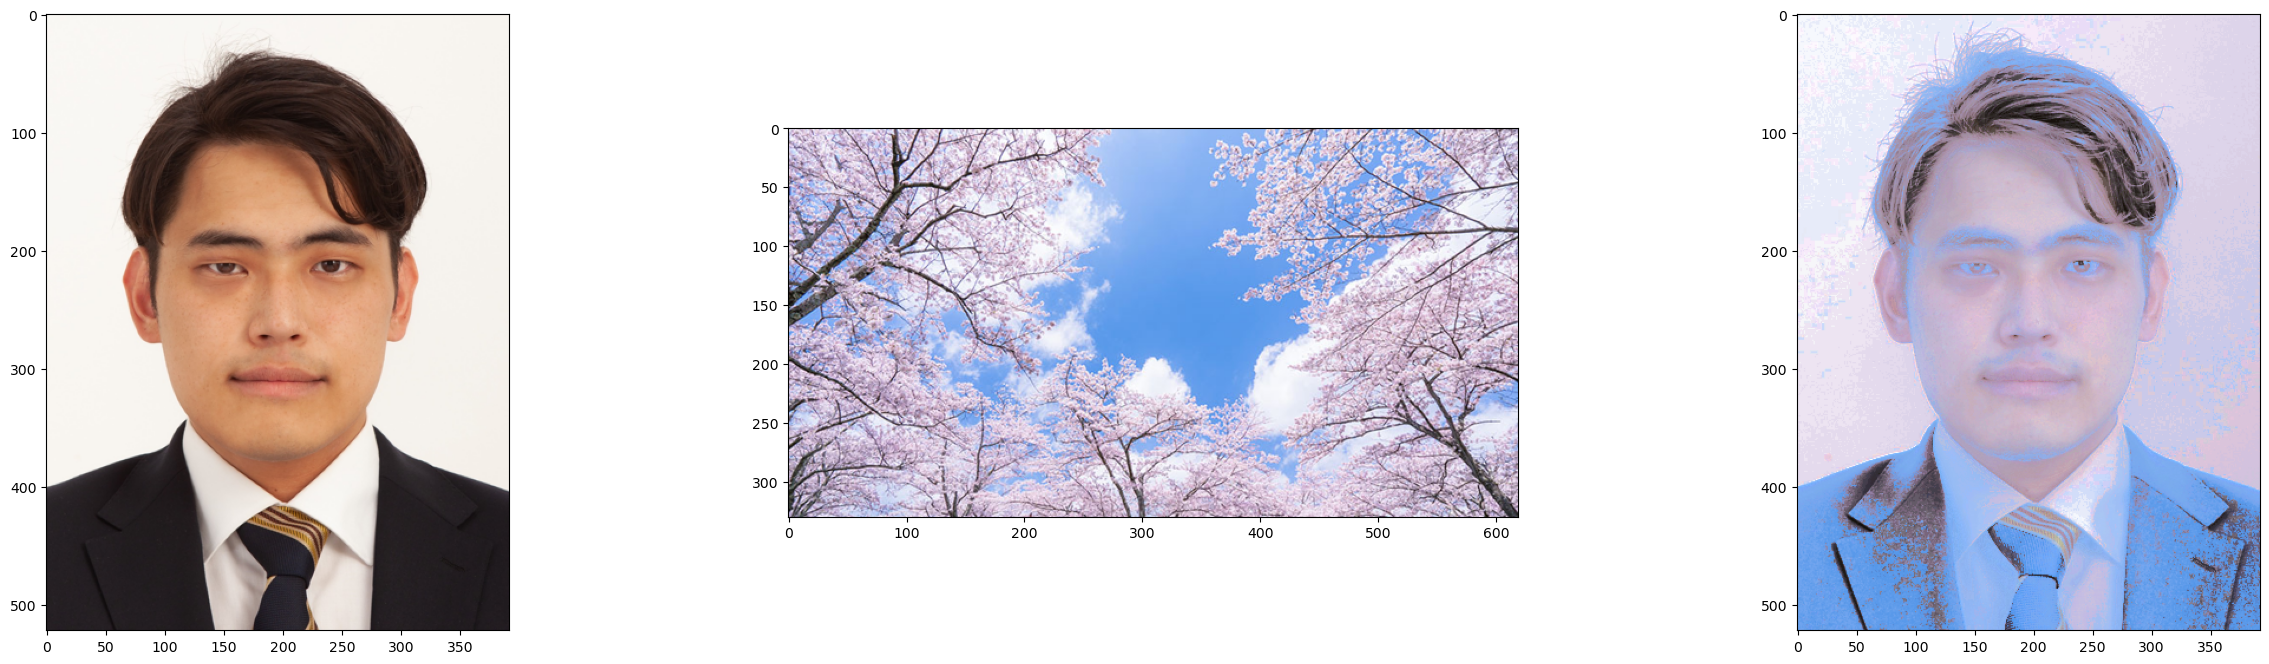

In [27]:
resolution = 640 * 320 # 解像度
for source, target in [(3, 5)]:
    print(source, target)

    # 画像の読み込み
    im1 = Image.open('./imgs/source{}.jpg'.format(source)) # 画像の読み込み
    w1, h1 = im1.size
    r = np.sqrt(resolution / (w1 * h1))
    im1 = im1.resize((int(w1 * r), int(h1 * r))) # 画像のリサイズ
    w1, h1 = im1.size
    x1 = np.array(im1).reshape(-1, 3)

    im2 = Image.open('./imgs/target{}.jpg'.format(target)) # 画像の読み込み
    w2, h2 = im2.size
    r = np.sqrt(resolution / (w2 * h2))
    im2 = im2.resize((int(w2 * r), int(h2 * r))) # 画像のリサイズ
    w2, h2 = im2.size
    x2 = np.array(im2).reshape(-1, 3)

    # k-means による点群の代表点の生成
    n = 500
    kmeans1 = MiniBatchKMeans(n, random_state=0)
    kmeans1.fit(x1)
    c1 = kmeans1.predict(x1)
    sx1 = kmeans1.cluster_centers_
    a = np.bincount(c1, minlength=n) / len(x1)

    kmeans2 = MiniBatchKMeans(n, random_state=0)
    kmeans2.fit(x2)
    c2 = kmeans2.predict(x2)
    sx2 = kmeans2.cluster_centers_
    b = np.bincount(c2, minlength=n) / len(x2)

    C = np.linalg.norm(sx1.reshape(-1, 1, 3) - sx2.reshape(1, -1, 3), axis=2) ** 2 # コスト行列の計算
    P = ot.emd(a, b, C) # 最適輸送行列の計算

    csx1 = P @ sx2 / a.reshape(n, 1) # 式 (2.52)

    cx1 = x1.copy()
    for i in range(len(x1)):
        j = c1[i]
        cx1[i] = np.maximum(0, np.minimum(csx1[j] + x1[i] - sx1[j], 255)) # 式 (2.51)

    res = Image.fromarray(cx1.reshape(h1, w1, 3))
    fig = plt.figure(figsize=(32, 8))
    ax = fig.add_subplot(131)
    ax.imshow(im1)
    ax = fig.add_subplot(132)
    ax.imshow(im2)
    ax = fig.add_subplot(133)
    ax.imshow(res)